In [266]:
!pip install -q pandas numpy openpyxl statsmodels matplotlib seaborn scipy


[notice] A new release of pip available: 22.3 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import os

os.makedirs("dataset", exist_ok=True)

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt


plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['axes.titlepad'] = 20

In [3]:
import pandas as pd
import numpy as np


pd.set_option('display.float_format', lambda x: '%.4f' % x)

isColab = False # Colab에서 돌릴 때 파일 경로를 바꿔주기 위한 변수
fillNaN = False # Dataguide라서 NaN이 많은데, 이를 채울지 말지 결정하는 변수
MAX_YEAR = 4.0 # Main Quarter 추출 시 직전 N년간의 데이터 # float type 필수!
DEL_UNDER_YEAR = 3 * 4  # 12 quarters

ffill_lag = lambda col: col.where(col.notna(), col.shift(1))
bfill_lag = lambda col: col.where(col.notna(), col.shift(-1))

add_columns = lambda df, dict_df: pd.concat([df, pd.DataFrame(dict_df)], axis=1)

rawdata_path = "./dataguide" if isColab else './rawdata' 

##### Manipulation
- ffill bfill on asset, sales, "op_earn", "depre_amort"
- main_quarter
  - MAX_YEAR=5 -> 3 years
  - pass when missing "only once"
- bye bye continuity...
  - supplier financing avg...
  - delta cashflow avg...

In [4]:
oil = pd.read_excel(f"{rawdata_path}/oil_price_dubai.xlsx").rename(columns={'1열': 'date'})
# oil["oil_price_growth"] = oil["oil_price"]-oil["oil_price"].shift(1)
# oil.at[0, "oil_price_growth"] = oil.at[1, "oil_price_growth"]

oil["USDKRW"] = oil["USDKRW"].bfill() # google spread sheet USDKRW: NaN ~ 2003-09-30

oil["oil_price_USDKRW"] = oil["oil_price"] * oil["USDKRW"]
oil["oil_price_growth"] = oil["oil_price_growth"] * oil["USDKRW"] # / 1000
oil["oil_price_growth"] = oil["oil_price_growth"] #.shift(1) # 3개월 과거 데이터를 사용하기 위해 shift

print(oil.columns)
print(oil["date"].min(), oil["date"].max())
oil.tail()

Index(['date', 'oil_price', 'oil_price_growth', 'excel_date', 'USDKRW',
       'oil_price_USDKRW'],
      dtype='object')
2000-03-31 00:00:00 2024-09-30 00:00:00


,date,oil_price,oil_price_growth,excel_date,USDKRW,oil_price_USDKRW
94,2023-09-30,93.2400,25024.2243,45199,1351.9300,126053.9532
95,2023-12-31,77.5700,-20269.6151,45291,1293.5300,100339.1221
96,2024-03-31,86.6300,12188.3274,45382,1345.2900,116542.4727
97,2024-06-30,84.1100,-3478.3056,45473,1380.2800,116095.3508
98,2024-09-30,73.7600,-13551.2550,45565,1309.3000,96573.9680


<Axes: >

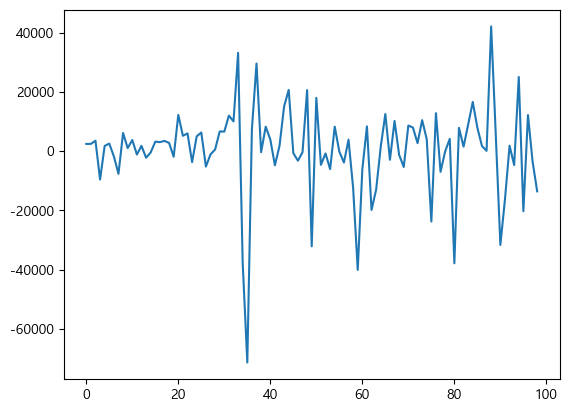

In [5]:
oil.oil_price_growth.plot()

In [6]:
# 제공된 파일 및 시트 구조
file_sheets = {
    "김도연1.xlsx": ['depre_amort', 'depre', 'age', 'n_acq_intangi'],
    "김도연2.xlsx": ['tangi', 'intangi', 'cash'],
    "한민지.xlsx": ['payab', 'invent', 'const_receiv2'],
    "오영식.xlsx": ['receiv', 'st_debt', 'lt_debt', 't_debt', 'const_receiv1'],
    "dataguide_1214.xlsx": ['amort', 'defer_tax_debt', 'common_mktcap', 'prefer_mktcap',
        'asset', 'exchange', 'ind_code', 'ind_code_m', 'ind_code_s', 'ind_code_d', 'sales', 'op_earn', 'n_acq_tangi']
}

dfs = {}

for file, sheets in file_sheets.items():
    for sheet in sheets:
        try:
            if sheet not in dfs:
                dfs[sheet] = pd.read_excel(f"{rawdata_path}/{file}", sheet_name=sheet)
        except Exception as e:
            print(f"오류 발생 - 파일: {file}, 시트: {sheet}, 원인: {e}")

for key, df in dfs.items():
    print(f"키: {key}, 데이터프레임 크기: {df.shape}")

키: depre_amort, 데이터프레임 크기: (113, 3775)
키: depre, 데이터프레임 크기: (113, 3775)
키: age, 데이터프레임 크기: (15, 3775)
키: n_acq_intangi, 데이터프레임 크기: (113, 3775)
키: tangi, 데이터프레임 크기: (113, 3775)
키: intangi, 데이터프레임 크기: (113, 3775)
키: cash, 데이터프레임 크기: (113, 3775)
키: payab, 데이터프레임 크기: (113, 3775)
키: invent, 데이터프레임 크기: (113, 3775)
키: const_receiv2, 데이터프레임 크기: (113, 3775)
키: receiv, 데이터프레임 크기: (113, 3775)
키: st_debt, 데이터프레임 크기: (113, 3775)
키: lt_debt, 데이터프레임 크기: (113, 3775)
키: t_debt, 데이터프레임 크기: (113, 3775)
키: const_receiv1, 데이터프레임 크기: (113, 3775)
키: amort, 데이터프레임 크기: (113, 3781)
키: defer_tax_debt, 데이터프레임 크기: (113, 3781)
키: common_mktcap, 데이터프레임 크기: (113, 3781)
키: prefer_mktcap, 데이터프레임 크기: (113, 3781)
키: asset, 데이터프레임 크기: (113, 3781)
키: exchange, 데이터프레임 크기: (113, 3775)
키: ind_code, 데이터프레임 크기: (113, 3775)
키: ind_code_m, 데이터프레임 크기: (113, 3782)
키: ind_code_s, 데이터프레임 크기: (113, 3782)
키: ind_code_d, 데이터프레임 크기: (113, 3782)
키: sales, 데이터프레임 크기: (113, 3781)
키: op_earn, 데이터프레임 크기: (113, 3781)
키: n_acq_tangi, 데이터프레임 크기:

In [7]:
rows_to_drop = list(range(0, 13)) # 0 ~ 12

for k in dfs.keys():
  dfs[k].columns = dfs[k].iloc[7] # firmcode line을 column명으로 지정
  dfs[k] = dfs[k].drop(rows_to_drop, axis=0)
  dfs[k] = dfs[k].set_index("Symbol").reset_index().melt(
        id_vars=["Symbol"],
        var_name="firmcode",
        value_name=k,
    ).rename(columns={"Symbol": "date"})
  print(f"키: {k}, 데이터프레임 크기: {dfs[k].shape}")

C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: depre_amort, 데이터프레임 크기: (377400, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: depre, 데이터프레임 크기: (377400, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: age, 데이터프레임 크기: (7548, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: n_acq_intangi, 데이터프레임 크기: (377400, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: tangi, 데이터프레임 크기: (377400, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: intangi, 데이터프레임 크기: (377400, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: cash, 데이터프레임 크기: (377400, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: payab, 데이터프레임 크기: (377400, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: invent, 데이터프레임 크기: (377400, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: const_receiv2, 데이터프레임 크기: (377400, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: receiv, 데이터프레임 크기: (377400, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: st_debt, 데이터프레임 크기: (377400, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: lt_debt, 데이터프레임 크기: (377400, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: t_debt, 데이터프레임 크기: (377400, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: const_receiv1, 데이터프레임 크기: (377400, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: amort, 데이터프레임 크기: (378000, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: defer_tax_debt, 데이터프레임 크기: (378000, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: common_mktcap, 데이터프레임 크기: (378000, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: prefer_mktcap, 데이터프레임 크기: (378000, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: asset, 데이터프레임 크기: (378000, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: exchange, 데이터프레임 크기: (377400, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: ind_code, 데이터프레임 크기: (377400, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: ind_code_m, 데이터프레임 크기: (378100, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: ind_code_s, 데이터프레임 크기: (378100, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: ind_code_d, 데이터프레임 크기: (378100, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: sales, 데이터프레임 크기: (378000, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: op_earn, 데이터프레임 크기: (378000, 3)


C:\Users\DYK\AppData\Roaming\Python\Python311\site-packages\pandas\core\indexes\base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


키: n_acq_tangi, 데이터프레임 크기: (378000, 3)


In [8]:
df = dfs["asset"][["date", "firmcode"]]
for c in dfs.keys():
    df = pd.merge(df, dfs[c], on=["date", "firmcode"], how="left")

for v in df.columns:
    if v in ["date", "firmcode", "age", "exchange", "ind_code"]:
        continue
    df[v] = df[v].astype(float)

df["year"] = df["date"].dt.year
df["month"] = df["date"].dt.month

df = df[df["date"].dt.is_month_end] # 월말 데이터만 사용 
df = df[df["month"].isin([3, 6, 9, 12])].sort_values(["firmcode", "date"])

df = pd.merge(df, oil, on="date", how="left")
print("Oil price NaN: ", df["oil_price_growth"].isna().sum())

print(
    df.shape, 
    df["firmcode"].value_counts(dropna=False).value_counts(), # 3780개 회사는 모두 99개의 데이터를 가지고 있음
    df["date"].value_counts(dropna=False).value_counts(),  # 전체 99개일자마다 3780개 회사가 존재함
    df[['date', 'firmcode']].value_counts(dropna=False).value_counts(), # date, firmcode 조합은 unique함
)

Oil price NaN:  0
(374220, 37) count
99    3780
Name: count, dtype: int64 count
3780    99
Name: count, dtype: int64 count
1    374220
Name: count, dtype: int64


In [9]:
# Sales, Asset에 0이 기입된 건수
for v in ["sales", "asset"]:
    print(v, df.groupby("firmcode")[v].sum().value_counts(dropna=False)[0])

sales 509
asset 208


In [10]:
df["age"] = df.groupby("firmcode")["age"].ffill().bfill()
df["age"] = df["year"] - pd.to_datetime(df["age"], format="%Y%m%d").dt.year #.dt.strftime("%Y-%m-%d")

df = df.sort_values(["firmcode", "date"])

if fillNaN:
    for v in ["asset", "sales", "op_earn", "depre_amort"]:
        df[v] = df.groupby("firmcode").apply(lambda x: bfill_lag(ffill_lag(x[v]))).reset_index(drop=True)

# 건설업의 매출채권 성격
if "const_receiv1" in df.columns:
    df.loc[df["ind_code"] == "F", "receiv"] = df.loc[df["ind_code"] == "F", ["receiv", "const_receiv1", "const_receiv2"]].sum(axis=1)
    df = df.drop(columns=["const_receiv1", "const_receiv2"])

# Operating Earnings
if "ebitda" not in df.columns:
    df["ebitda"] = df["op_earn"] + df["depre_amort"]
    print(df[["ebitda", "op_earn", "depre_amort"]].isna().sum())
    df = df.drop(columns=["op_earn", "depre_amort"])

df["n_ppe"] = df["tangi"] + df["intangi"]
for v in ["sales", "asset", "ebitda", "n_ppe"]:
    df.loc[df[v] == 0, v] = None

# 날짜 오름차순 정렬이라서 shift(1)이 전날 데이터를 가져옴
df["asset_lag"] = df.groupby("firmcode")["asset"].shift(1) # = atq
df["drop_size_dummy"] = df["asset_lag"] > df["asset_lag"].quantile(0.66)



C:\Users\DYK\AppData\Local\Temp\ipykernel_21584\4021516687.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df["age"] = df.groupby("firmcode")["age"].ffill().bfill()


ebitda         173715
op_earn        173084
depre_amort    173715
dtype: int64


In [11]:
df["cashflow"] = df["ebitda"] / df["asset_lag"]

lower_bound = df['cashflow'].quantile(0.01)
upper_bound = df['cashflow'].quantile(0.99)
df.loc[df['cashflow'] < lower_bound, 'cashflow'] = None
df.loc[df['cashflow'] > upper_bound, 'cashflow'] = None

df["cashflow_01"] = df["cashflow"] + df.groupby("firmcode")["cashflow"].shift(-1)

In [12]:
df[df["ebitda"].notna() & df["asset_lag"].notna()]["cashflow"].isna().sum() # 확인용

3558

In [13]:
df[["date", "asset", "asset_lag"]].tail(3) # lag 방향 확인용

,date,asset,asset_lag
374217,2024-03-31,82466916000.0000,92151554000.0000
374218,2024-06-30,75090094000.0000,82466916000.0000
374219,2024-09-30,72185081000.0000,75090094000.0000


In [14]:
firm_obs = df.shape[0] / df["firmcode"].nunique()
print(df.shape[0], df["firmcode"].nunique(), firm_obs)

df = df[~df["ind_code"].isin(["K", "E", "D"])]
# K: 금융업
# D: 전기, 가스, 증기 및 공기 조절 공급업
# E: 수도, 하수, 및 폐기물 처리, 원료 재생업

firm_obs = df.shape[0] / df["firmcode"].nunique()
print(df.shape[0], df["firmcode"].nunique(), firm_obs)

374220 3780 99.0
332244 3356 99.0


In [15]:
df["firmcode"].value_counts(dropna=False).value_counts()

count
99    3356
Name: count, dtype: int64

In [16]:
df["payab_to_sales"] = df["payab"] / df["sales"]
df["payab_to_asset"] = df["payab"] / df["asset"]
df["receiv_to_sales"] = df["receiv"] / df["sales"]
df["receiv_to_asset"] = df["receiv"] / df["asset"]
df["invent_to_sales"] = df["invent"] / df["sales"]
df["invent_to_asset"] = df["invent"] / df["asset"]

df["st_debt_to_asset"] = df["st_debt"] / df["asset"]
df["st_debt_to_sales"] = df["lt_debt"] / df["sales"]
df["st_asset"] = df["receiv"] + df["invent"]

In [17]:
for v in ["sales", "st_asset", "payab"]:
    df[f"log_{v}"] = (1+df[v].astype(float)).apply(np.log) # default of base is e

df["size"] = (1 + df["asset_lag"].astype(float)).apply(np.log)
df["book_lev"] = (df["st_debt"] + df["lt_debt"]) / df["asset"]

df["capex"] = df["n_acq_tangi"] + df["n_acq_intangi"]
df["investment"] = df["capex"] / df.groupby("firmcode")["n_ppe"].shift(1)
df["n_ppe_to_asset"] = df["n_ppe"] / df["asset"]

df["q"] = df[[
    "common_mktcap", "prefer_mktcap", "st_debt", "lt_debt", "defer_tax_debt"
]].sum(axis=1) / df["asset_lag"]

In [18]:
groups = df.groupby("firmcode")

avg_cols = [
    "cashflow", "age", "size", "q",
    "payab_to_sales", 
    "log_sales", "log_st_asset", "log_payab", "investment" # (t, t+1), (t+2, t+3)
]

lagging = {
    v: [f"{v}_lag{i}" for i in range(1, 5)] for v in avg_cols
}

df = add_columns(
    df,  {v[i-1]: groups[k].shift(i) for k, v in lagging.items() for i in range(1, len(v) + 1)}
)
df = add_columns(
    df, {f"avg_{v}": df[lagging[v]].mean(axis=1) for v in avg_cols[:4]}
)


df["delta_cashflow"] = df["cashflow"] - df["avg_cashflow"]
# df.loc[df["avg_cashflow"].isna(), "delta_cashflow"] = df.loc[df["avg_cashflow"].isna(), "cashflow"] - df.loc[df["avg_cashflow"].isna(), "cashflow_lag1"]
df.loc[df["cashflow"].isna(), "delta_cashflow"] = None
df["sup_fin"] = df[lagging["payab_to_sales"]].mean(axis=1)
df["sup_fin_tercile"] = pd.qcut(df["sup_fin"], 3, labels=["low", "mid", "top"])


df = add_columns(
    df, {f"{v}_lag_mean": df[lagging[v]].mean(axis=1) for v in avg_cols[-4:]}
)


leading = {
    v: [f"{v}_lead{i}" for i in range(1, 4)] for v in avg_cols[2:]
}

df = add_columns(
    df,  {v[i-1]: groups[k].shift(-i) for k, v in leading.items() for i in range(1, len(v) + 1)}
)


df = add_columns(
    df, {f"delta_{v}_01": df[[f"{v}", f"{v}_lead1"]].mean(axis=1) - df[f"{v}_lag_mean"] for v in avg_cols[-4:]}
)
df = add_columns(
    df, {f"delta_{v}_23": df[[f"{v}_lead2", f"{v}_lead3"]].mean(axis=1) - df[f"{v}_lag_mean"] for v in avg_cols[-4:]}
)


for v in [
    lagging.values(), leading.values(), 
    [[f"{v}_lag_mean" for v in avg_cols[-4:]]]
]:
    for vv in v:
        df = df.drop(columns=vv)

In [19]:
df["sup_fin_tercile"].value_counts(dropna=False)

sup_fin_tercile
NaN    159128
top     57706
low     57705
mid     57705
Name: count, dtype: int64

In [20]:
t = df.groupby("firmcode")["asset"].count()
df = df[~df["firmcode"].isin(t[t < DEL_UNDER_YEAR].index)]

In [21]:
df.columns

Index(['date', 'firmcode', 'depre', 'age', 'n_acq_intangi', 'tangi', 'intangi',
       'cash', 'payab', 'invent', 'receiv', 'st_debt', 'lt_debt', 't_debt',
       'amort', 'defer_tax_debt', 'common_mktcap', 'prefer_mktcap', 'asset',
       'exchange', 'ind_code', 'ind_code_m', 'ind_code_s', 'ind_code_d',
       'sales', 'n_acq_tangi', 'year', 'month', 'oil_price',
       'oil_price_growth', 'excel_date', 'USDKRW', 'oil_price_USDKRW',
       'ebitda', 'n_ppe', 'asset_lag', 'drop_size_dummy', 'cashflow',
       'cashflow_01', 'payab_to_sales', 'payab_to_asset', 'receiv_to_sales',
       'receiv_to_asset', 'invent_to_sales', 'invent_to_asset',
       'st_debt_to_asset', 'st_debt_to_sales', 'st_asset', 'log_sales',
       'log_st_asset', 'log_payab', 'size', 'book_lev', 'capex', 'investment',
       'n_ppe_to_asset', 'q', 'avg_cashflow', 'avg_age', 'avg_size', 'avg_q',
       'delta_cashflow', 'sup_fin', 'sup_fin_tercile', 'delta_log_sales_01',
       'delta_log_st_asset_01', 'delta_log_pa

In [22]:
# null 값 존재하는 것만 info
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 296406 entries, 99 to 374219
Data columns (total 72 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   date                   296406 non-null  datetime64[ns]
 1   firmcode               296406 non-null  object        
 2   depre                  185776 non-null  float64       
 3   age                    296406 non-null  int32         
 4   n_acq_intangi          210447 non-null  float64       
 5   tangi                  178695 non-null  float64       
 6   intangi                178695 non-null  float64       
 7   cash                   178695 non-null  float64       
 8   payab                  178695 non-null  float64       
 9   invent                 178695 non-null  float64       
 10  receiv                 175588 non-null  float64       
 11  st_debt                178695 non-null  float64       
 12  lt_debt                178695 non-null  float64 

In [23]:
print(
    df["firmcode"].nunique(),
    df.shape,
    df["cashflow"].isna().sum(),
    df["cashflow"].isna().sum() / df.shape[0],
    sep="\n"
)

2994
(296406, 72)
134530
0.4538707043717064


In [24]:
# firm 마다 분기별 데이터가 있는지 확인
# 모든 분기에 대해 데이터가 있는 firmcode만 남기기
(df["firmcode"].value_counts() == 99).sum()

2994

In [68]:
df["cashflow"] = df["cashflow"].astype(float)
groups = df.reset_index(drop=True).groupby(["firmcode", "month"])


lag_cols = [f"cashflow_lag{i}" for i in range(1, 4*int(MAX_YEAR+1))]
for i in range(1, 4*int(MAX_YEAR+1)):
    df[lag_cols[i-1]] = groups["cashflow"].shift(i)


skip_quarter = 4 # previous 1 year = 4 quarters
quarter_lag = [None] + [lag_cols[i::4][:int(MAX_YEAR)] for i in range(skip_quarter-1, skip_quarter-1+4)]
for i, v in enumerate(quarter_lag):
    if not i: continue
    print(f"Q{i}", quarter_lag[i])
    df[f"cashflow_q{i}_mean"] = df[quarter_lag[i]].mean(axis=1)
    df[f"cashflow_q{i}_cnt"] = df[quarter_lag[i]].notna().sum(axis=1)

df["firm_type"] = df[[f"cashflow_q{i}_mean" for i in range(1, 5)]].idxmax(axis=1).str[-6].astype(float)
df["firm_type_cnt"] = df[[f"cashflow_q{i}_cnt" for i in range(1, 5)]].sum(axis=1) >= ((MAX_YEAR) * 4) 
 # - 1)

df = df.drop(columns=lag_cols)

Q1 ['cashflow_lag4', 'cashflow_lag8', 'cashflow_lag12', 'cashflow_lag16']
Q2 ['cashflow_lag5', 'cashflow_lag9', 'cashflow_lag13', 'cashflow_lag17']
Q3 ['cashflow_lag6', 'cashflow_lag10', 'cashflow_lag14', 'cashflow_lag18']
Q4 ['cashflow_lag7', 'cashflow_lag11', 'cashflow_lag15', 'cashflow_lag19']


C:\Users\DYK\AppData\Local\Temp\ipykernel_21584\1519055372.py:18: FutureWarning: The behavior of DataFrame.idxmax with all-NA values, or any-NA and skipna=False, is deprecated. In a future version this will raise ValueError
  df["firm_type"] = df[[f"cashflow_q{i}_mean" for i in range(1, 5)]].idxmax(axis=1).str[-6].astype(float)


In [69]:
df["firm_type_cnt"].value_counts()

firm_type_cnt
False    292339
True       4067
Name: count, dtype: int64

In [70]:
df.sort_values(["firmcode", "date"])[[
    "firmcode", "date", "cashflow", "firm_type", 
]].dropna(subset=["firm_type"]).head(20)

,firmcode,date,cashflow,firm_type
50898,A007690,2003-03-31,0.0191,1.0000
50899,A007690,2003-06-30,0.0131,1.0000
50900,A007690,2003-09-30,0.0080,1.0000
50903,A007690,2004-06-30,0.0281,1.0000
50904,A007690,2004-09-30,0.0226,1.0000
50905,A007690,2004-12-31,0.0253,1.0000
50906,A007690,2005-03-31,0.0273,1.0000
50907,A007690,2005-06-30,0.0133,1.0000
50908,A007690,2005-09-30,0.0137,1.0000
50909,A007690,2005-12-31,0.0265,1.0000


In [71]:
df.groupby(["firmcode","year"])["firm_type"].first().to_frame().reset_index()

,firmcode,year,firm_type
0,A000020,2000,NaN
1,A000020,2001,NaN
2,A000020,2002,NaN
3,A000020,2003,NaN
4,A000020,2004,NaN
...,...,...,...
74845,A950220,2020,NaN
74846,A950220,2021,NaN
74847,A950220,2022,NaN
74848,A950220,2023,NaN


In [72]:
df["month"] = pd.to_datetime(df["date"]).dt.month
df.loc[~df["firm_type"].isna(), "main_quarter"] = (df.loc[~df["firm_type"].isna(),"month"]//3 == df.loc[~df["firm_type"].isna(),"firm_type"]).astype(int)
df[["main_quarter", "firm_type"]].value_counts(dropna=False).sort_values().sort_index()

main_quarter  firm_type
0.0000        1.0000       29496
              2.0000       24989
              3.0000       24072
              4.0000       25547
              NaN          52430
1.0000        1.0000        9972
              2.0000        8319
              3.0000        8019
              4.0000        8016
              NaN          17739
NaN           NaN          87807
Name: count, dtype: int64

In [73]:
# df["date"] = df["date"].dt.strftime("%Y-%m-%d")

##### Plot - Date, Industry, Firm Type Frequency

In [74]:
def heatmap_frequency(col, data, title, transpose=True):
    if col == "date":
        data[col] = data[col].dt.strftime("%Y-%m")

    if isinstance(col, list):
        data = data[col + ["firm_type", "main_quarter"]]
    else:
        data = data[[col, "firm_type", "main_quarter"]]

    data = data.value_counts().sort_index().to_frame().unstack().fillna(0)
    if transpose:
        data = data.T
        plt.figure(figsize=(40, 5))
    else:
        plt.figure(figsize=(5, 50))
        
    sns.heatmap(
        data, annot=True, fmt=".0f", cmap="YlGnBu",
        cbar=True, square=transpose, xticklabels=True, yticklabels=True, 
        annot_kws={"fontsize": 12}, cbar_kws={"shrink": 0.5, "pad": 0.01}, robust=True
    )
    plt.xticks(rotation=45)
    plt.title(title, fontsize=15)
    plt.show()

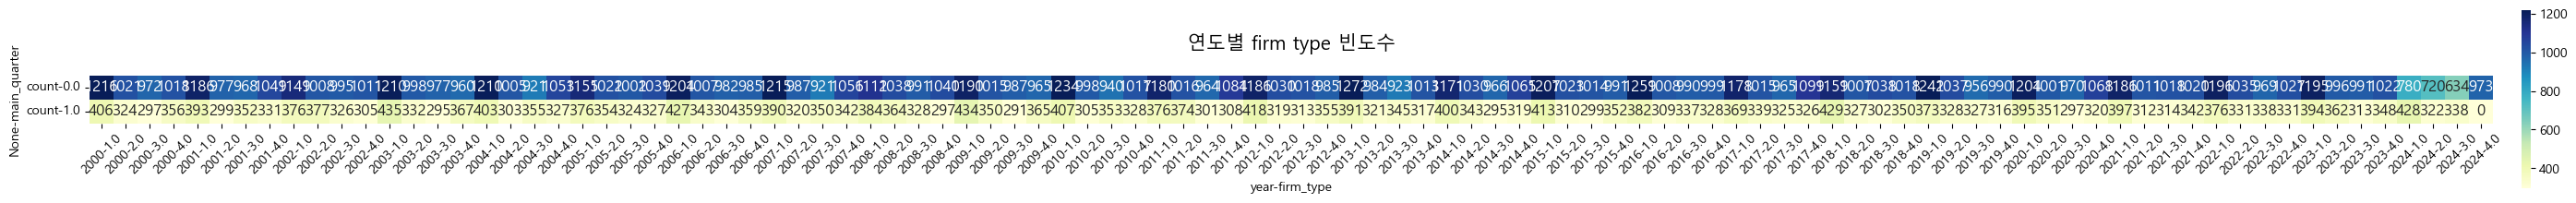

In [75]:
heatmap_frequency("year", df, "연도별 firm type 빈도수")

C:\Users\DYK\AppData\Local\Temp\ipykernel_21584\1326270945.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].dt.strftime("%Y-%m")


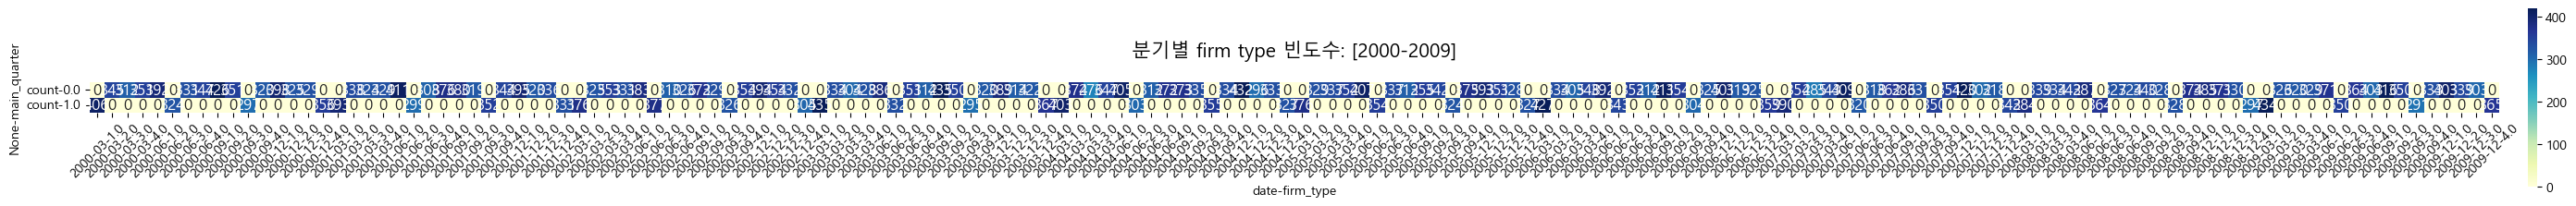

In [76]:
heatmap_frequency("date", df[df["year"]<2010], "분기별 firm type 빈도수: [2000-2009]")

C:\Users\DYK\AppData\Local\Temp\ipykernel_21584\1326270945.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].dt.strftime("%Y-%m")


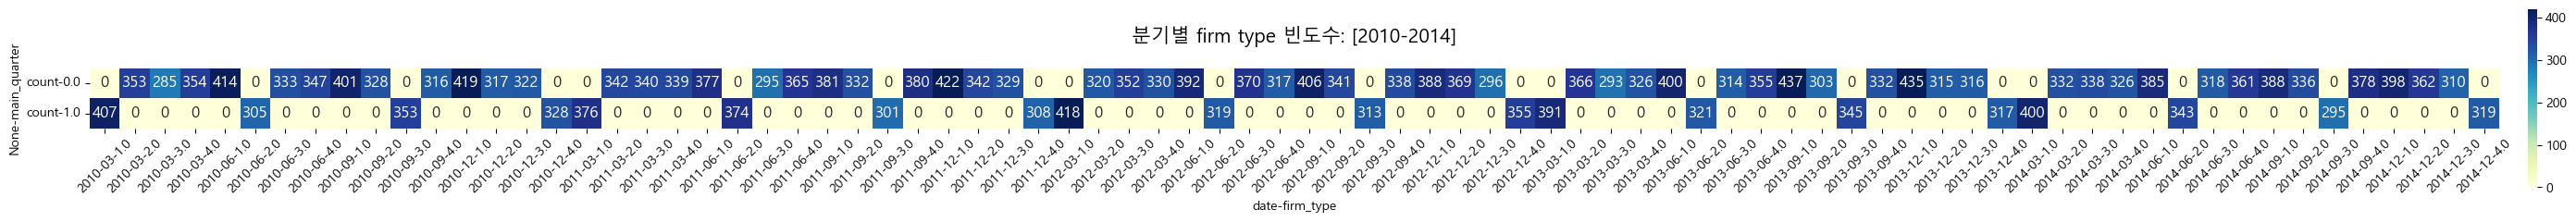

In [77]:
heatmap_frequency("date", df[(df["year"]>=2010) & (df["year"]<=2014)], "분기별 firm type 빈도수: [2010-2014]")

C:\Users\DYK\AppData\Local\Temp\ipykernel_26880\1326270945.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].dt.strftime("%Y-%m")


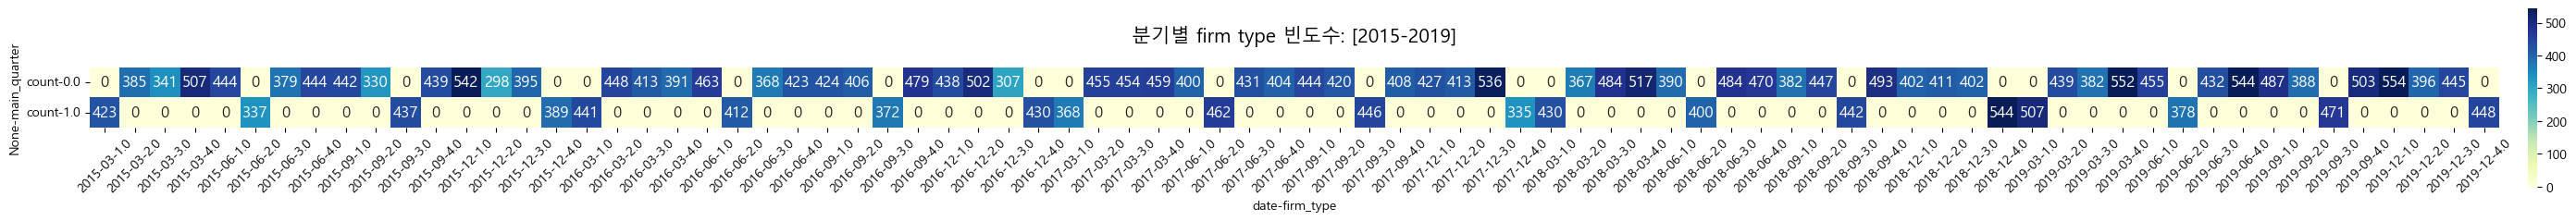

In [30]:
heatmap_frequency("date", df[(df["year"]>=2015) & (df["year"]<=2019)], "분기별 firm type 빈도수: [2015-2019]")

C:\Users\DYK\AppData\Local\Temp\ipykernel_26880\1326270945.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col] = data[col].dt.strftime("%Y-%m")


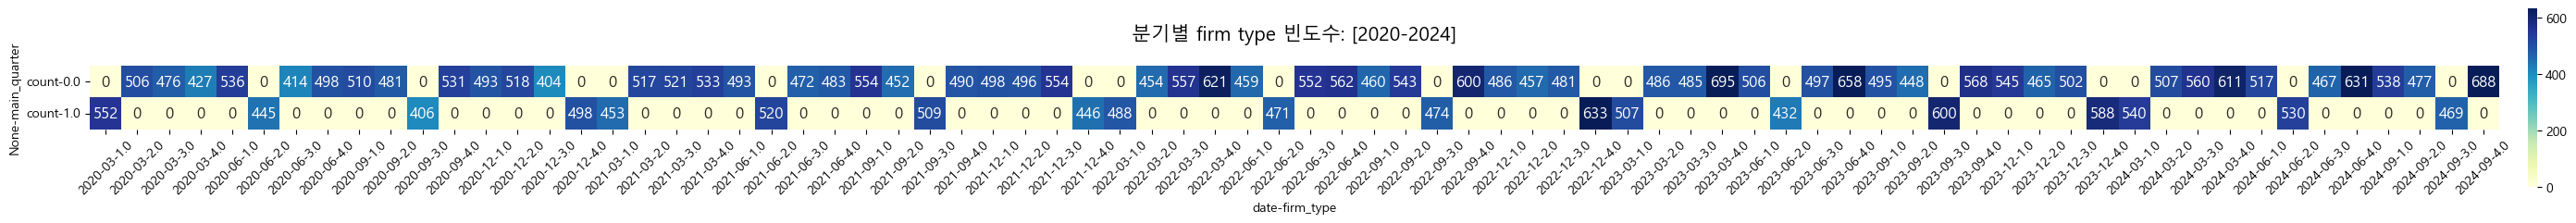

In [31]:
heatmap_frequency("date", df[(df["year"]>=2020) & (df["year"]<=2024)], "분기별 firm type 빈도수: [2020-2024]")

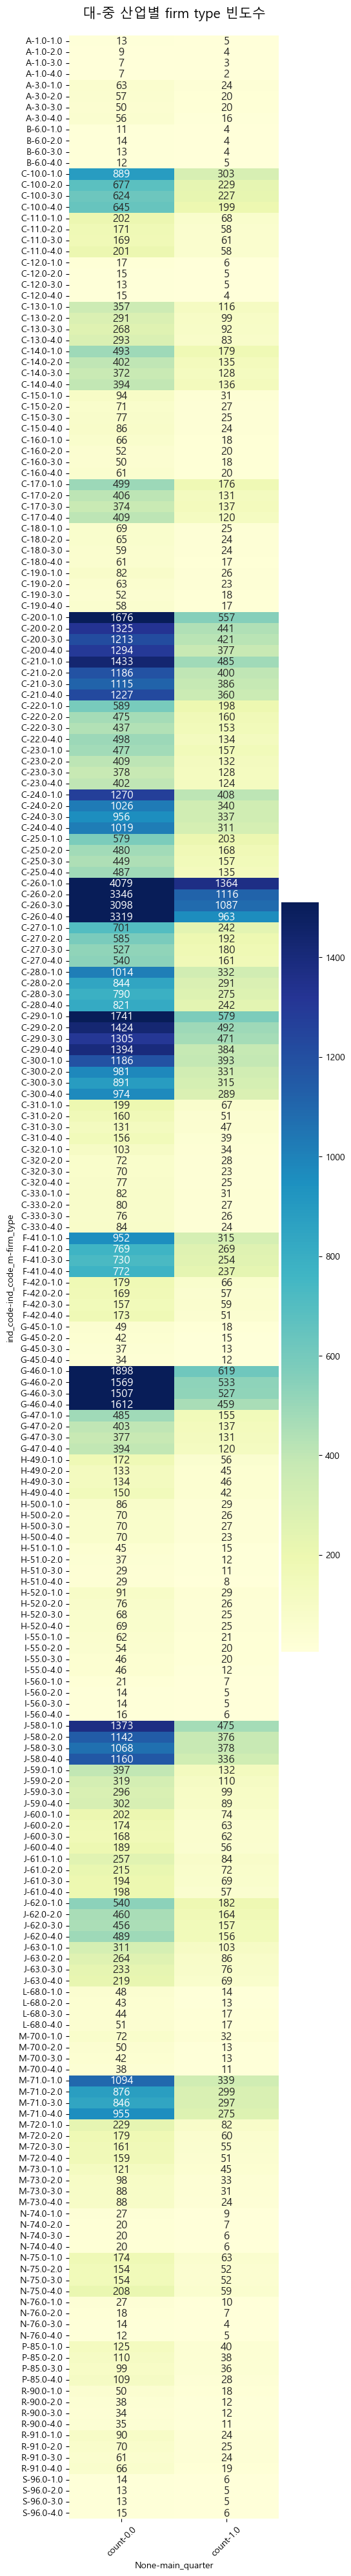

In [32]:
heatmap_frequency(["ind_code", "ind_code_m"], df, "대-중 산업별 firm type 빈도수", transpose=False)

In [78]:
df[df["delta_cashflow"].notna()]["date"].min()

Timestamp('2000-09-30 00:00:00')

In [79]:
df["delta_cashflow"].isna().sum() / df.shape[0]

0.46436306957349044

In [80]:
# df.loc[~df["delta_cashflow"].isna(), [
#     "firmcode", "date", "ind_code", "ind_code_m", 
#     "cashflow", "delta_cashflow", "sup_fin", "sup_fin_tercile", "ebitda", "asset_lag", "asset", "size"
# ]].to_csv("delta_cashflow.csv", index=False)

In [81]:
df = df.sort_values(["date", "firmcode"])

#### Save

In [59]:
df.to_csv("./dataset/working_capital_dataset_idxmin.csv", index=False, encoding="utf8")

## Table I
- includes firms with negative industry oil beta

In [60]:
pd.set_option('display.float_format', lambda x: '%.4f' % x)

In [61]:
summary_cols = (
    "log_sales", "delta_log_sales_01", "delta_log_sales_23",
    "size", "q", "cashflow", "cash", "book_lev", 
    "st_debt_to_asset", "st_debt_to_sales", 
    "payab_to_sales", "payab_to_asset", "receiv_to_sales", "receiv_to_asset", 
    "invent_to_sales", "invent_to_asset", 
    "delta_log_st_asset_01", "delta_log_st_asset_23", "investment", "n_ppe_to_asset"
)

summary_stats = ["count", "mean", "50%", "std", "min", "25%", "75%", "max"]


def summary_table(condition):
    global df, summary_cols, summary_stats
    summary = df.loc[condition, summary_cols].describe(include="all").T
    summary["count"] = summary["count"].astype(int)
    return summary[summary_stats]

def summary_info(condition):
    global df
    print("firm observations", df[condition]["firmcode"].nunique())
    print()
    t = df[condition]["drop_size_dummy"].value_counts().sort_index().to_frame()
    t["percentage"] = t / df[condition].shape[0] * 100

    print("top 33% lag of total asset", t, sep="\n")

    return df[condition]["ind_code"].value_counts().to_frame()

In [62]:
summary_info(df["firm_type_cnt"]==True)

firm observations 812

top 33% lag of total asset
                 count  percentage
drop_size_dummy                   
False             1966     55.9317
True              1549     44.0683


,count
ind_code,
C,2247
G,336
J,294
M,211
F,178
H,57
R,20
P,18
I,14


In [ ]:
# 아마도 이게 Table I - Panel A
summary_table(df["firm_type_cnt"]==True)

,count,mean,50%,std,min,25%,75%,max
log_sales,2427,24.5782,24.5019,1.8611,14.2748,23.4885,25.6130,30.3854
delta_log_sales_01,2429,0.0251,0.0259,0.4200,-6.3375,-0.0833,0.1414,5.0880
delta_log_sales_23,2395,0.0198,0.0444,0.5408,-8.7021,-0.1068,0.1879,5.9280
size,2580,26.5605,26.3718,1.5435,21.0481,25.5161,27.2983,32.1631
q,2580,1.0103,0.7504,1.1512,0.0000,0.5236,1.1759,19.5736
cashflow,2420,0.0127,0.0115,0.0186,-0.0728,0.0029,0.0215,0.1036
cash,2438,96682876206.0911,15866112315.0000,337095818281.0256,77000.0000,4998616522.5000,45942763000.0000,7274350000000.0000
book_lev,2438,0.2151,0.1878,0.2207,0.0000,0.0474,0.3321,3.0989
st_debt_to_asset,2438,0.1441,0.1077,0.1654,0.0000,0.0225,0.2177,2.5046
st_debt_to_sales,2426,41.3415,0.1726,1427.7089,0.0000,0.0156,0.7074,57613.9646


In [64]:
summary_info((df["firm_type_cnt"]==True) & (df["cashflow"].notna()))

firm observations 561

top 33% lag of total asset
                 count  percentage
drop_size_dummy                   
False              933     38.5537
True              1487     61.4463


,count
ind_code,
C,1583
G,256
M,189
J,146
F,126
H,55
R,18
I,14
L,10


In [ ]:
summary_table((df["firm_type_cnt"]==True) & (df["cashflow"].notna()))

,count,mean,50%,std,min,25%,75%,max
log_sales,2415,24.5724,24.4984,1.8592,14.2748,23.4827,25.6108,30.3854
delta_log_sales_01,2416,0.0233,0.0245,0.4200,-6.3375,-0.0839,0.1396,5.0880
delta_log_sales_23,2383,0.0190,0.0439,0.5411,-8.7021,-0.1068,0.1869,5.9280
size,2420,26.6282,26.4065,1.5192,21.3934,25.5624,27.3553,32.1631
q,2420,1.0638,0.7801,1.1540,0.0000,0.5585,1.1964,19.5736
cashflow,2420,0.0127,0.0115,0.0186,-0.0728,0.0029,0.0215,0.1036
cash,2419,95709234925.7420,15865559630.0000,335077747810.8227,77000.0000,4917478025.0000,45720530500.0000,7274350000000.0000
book_lev,2419,0.2149,0.1878,0.2208,0.0000,0.0473,0.3321,3.0989
st_debt_to_asset,2419,0.1440,0.1075,0.1656,0.0000,0.0223,0.2180,2.5046
st_debt_to_sales,2414,41.5454,0.1733,1431.2516,0.0000,0.0156,0.7079,57613.9646


In [66]:
summary_info((df["firm_type_cnt"]==True) & (df["cashflow"].notna()) & (df["sup_fin_tercile"]=="top"))

firm observations 199

top 33% lag of total asset
                 count  percentage
drop_size_dummy                   
False              235     42.6497
True               316     57.3503


,count
ind_code,
C,391
F,63
G,49
M,20
J,16
H,10
R,2


In [ ]:
# 아마도 이게 Table I - Panel B
summary_table((df["firm_type_cnt"]==True) & (df["sup_fin_tercile"]=="top"))

,count,mean,50%,std,min,25%,75%,max
log_sales,553,24.7101,24.5627,1.9336,15.2663,23.5342,25.6478,29.9216
delta_log_sales_01,553,0.0290,0.0208,0.4804,-4.9765,-0.0979,0.1385,5.0880
delta_log_sales_23,546,0.0350,0.0567,0.6161,-8.7021,-0.1038,0.1961,5.9280
size,556,26.5781,26.2723,1.5659,22.2960,25.5042,27.2072,31.3589
q,556,0.9094,0.6889,1.0997,0.0000,0.4864,1.0057,19.0705
cashflow,551,0.0094,0.0091,0.0187,-0.0606,0.0014,0.0165,0.1036
cash,553,112937208602.4593,14415079000.0000,341080484227.9406,203000.0000,4104167000.0000,39214544000.0000,3070472000000.0000
book_lev,553,0.2256,0.2231,0.2201,0.0000,0.0560,0.3258,2.7264
st_debt_to_asset,553,0.1574,0.1303,0.1688,0.0000,0.0348,0.2434,2.5046
st_debt_to_sales,553,1.0347,0.1935,7.6286,0.0000,0.0163,0.5692,148.8021
